In [1]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Step 1: Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Multiply with weights
        x = self.lin(x)

        # Step 3: Calculate the normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Propagate the embeddings to the next layer
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        # Normalize node features.
        return norm.view(-1, 1) * x_j


class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [3]:
def plot_dataset(dataset):
    edges_raw = dataset.data.edge_index.numpy()
    edges = [(x, y) for x, y in zip(edges_raw[0, :], edges_raw[1, :])]
    labels = dataset.data.y.numpy()

    G = nx.Graph()
    G.add_nodes_from(list(range(np.max(edges_raw))))
    G.add_edges_from(edges)
    plt.subplot(111)
    options = {
                'node_size': 30,
                'width': 0.2,
    }
    nx.draw(G, with_labels=False, node_color=labels.tolist(), cmap=plt.cm.tab10, font_weight='bold', **options)
    plt.show()

In [4]:
def test(data, train=True):
    model.eval()

    correct = 0
    pred = model(data).max(dim=1)[1]

    if train:
        correct += pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
        return correct / (len(data.y[data.train_mask]))
    else:
        correct += pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
        return correct / (len(data.y[data.test_mask]))

In [7]:
def train(data, plot=False):
    train_accuracies, test_accuracies = list(), list()
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        train_acc = test(data)
        test_acc = test(data, train=False)
        if len(test_accuracies) > 0:
            if (test_acc > test_accuracies[-1]):
                torch.save(model, "./cora_best.pth")
        
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        
        print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
              format(epoch, loss, train_acc, test_acc))
        
    if plot:
        plt.plot(train_accuracies, label="Train accuracy")
        plt.plot(test_accuracies, label="Validation accuracy")
        plt.xlabel("# Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='upper right')
        plt.show()

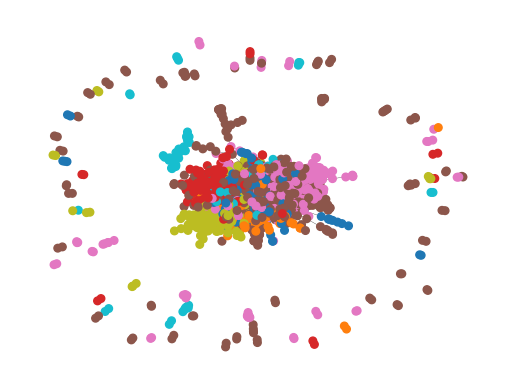

Epoch: 000, Loss: 1.96085, Train Acc: 0.22857, Test Acc: 0.34600
Epoch: 001, Loss: 1.91181, Train Acc: 0.42857, Test Acc: 0.45100
Epoch: 002, Loss: 1.82861, Train Acc: 0.59286, Test Acc: 0.53300
Epoch: 003, Loss: 1.73370, Train Acc: 0.71429, Test Acc: 0.62700
Epoch: 004, Loss: 1.65850, Train Acc: 0.76429, Test Acc: 0.67000
Epoch: 005, Loss: 1.54886, Train Acc: 0.82143, Test Acc: 0.68200
Epoch: 006, Loss: 1.43976, Train Acc: 0.85714, Test Acc: 0.69400
Epoch: 007, Loss: 1.33984, Train Acc: 0.88571, Test Acc: 0.71300
Epoch: 008, Loss: 1.23012, Train Acc: 0.90000, Test Acc: 0.74000
Epoch: 009, Loss: 1.18715, Train Acc: 0.92857, Test Acc: 0.75500
Epoch: 010, Loss: 1.07160, Train Acc: 0.92857, Test Acc: 0.76900
Epoch: 011, Loss: 0.95761, Train Acc: 0.94286, Test Acc: 0.77500
Epoch: 012, Loss: 0.86012, Train Acc: 0.94286, Test Acc: 0.78300
Epoch: 013, Loss: 0.83177, Train Acc: 0.95000, Test Acc: 0.78800
Epoch: 014, Loss: 0.69573, Train Acc: 0.95714, Test Acc: 0.79000
Epoch: 015, Loss: 0.63470

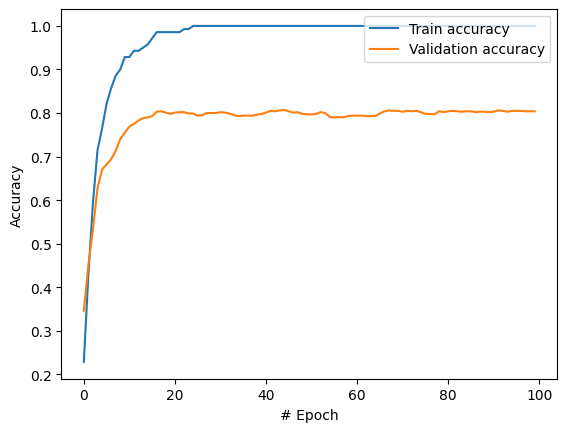

In [8]:
dataset_list = ["Cora", "PubMed"]

# print("Training on {}".format(data))
dataset = Planetoid(root='./data', name="Cora")



plot_dataset(dataset)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

train(data, plot=True)